In [1]:
import sys

from openpyxl import Workbook
from openpyxl.utils import get_column_letter

import pandas as pd

import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
    tracename="WDEV_0"
    file = open(tracename)

    page_size = 4

    update_count = 0

    entry = {"lpn": 0, "access_time": 0.0, "update_time": 0.0, "update_count": 0, "update_min": 0, "update_max": 0}
    

    large_lpn = 0

    capacity = 32 * 1024 * 1024  # 128G SSD = 32 * 1024* 1024*4KB
    
    #maptable = pd.DataFrame([ [0.0,0.0,0,0.0,0.0,0.0,0] for i in range(0, capacity)],columns=['access_time', 'update_interval', 'update_count', 'update_avg', "update_min", "update_max", "write_flag"])
    maptable = [{"access_time": 0.0, "update_interval": 0.0, "update_count": 0, "update_avg": 0.0, "update_min": 1.0 * 10**12, "update_max": 0.0, "write_flag": 0} for i in range(0, capacity)]  # write_flag =1 表示已经被写

    print("初始化完成 maptable:", len(maptable), sys.getsizeof(maptable) / (1024 * 1024))


    #print("初始化完成 maptable:", maptable.index,maptable.columns, sys.getsizeof(maptable) / (1024 * 1024))
    
    
    #trace df
    #tracedf=pd.read_table(tracename,sep=" ",header=None)

    #file = open(tracename)

    while 1:
        lines = file.readlines(100000)
        if not lines:
            break
        for line in lines:

            tmp = line.split()

            #print(tmp)
  

            if(int(tmp[4]) == 1):  # read

                first_lpn = int(int(tmp[2]) / page_size) % capacity

                while(first_lpn <= int(int(tmp[2]) / page_size + int(tmp[3]) / page_size) % capacity):

                    #print("first_lpn", first_lpn)

                    if(maptable[first_lpn]['write_flag'] == 1):  # 被写过

                        # maptable[int(int(tmp[2]) / page_size)]['access_time']=float(tmp[0]) #本次访问的时间

                        maptable[first_lpn]['update_interval'] = float(tmp[0]) - maptable[first_lpn]['access_time']  # 本次访问的时间

                        maptable[first_lpn]['update_count'] = maptable[first_lpn]['update_count'] + 1

                        # if(maptable[first_lpn]['update_interval'] <= 10):

                        #     print(tmp)

                        if(maptable[first_lpn]['update_min'] > maptable[first_lpn]['update_interval']):

                            maptable[first_lpn]['update_min'] = maptable[first_lpn]['update_interval']

                        if(maptable[first_lpn]['update_max'] < maptable[first_lpn]['update_interval']):

                            maptable[first_lpn]['update_max'] = maptable[first_lpn]['update_interval']

                        maptable[first_lpn]['update_avg'] = maptable[first_lpn]['update_avg'] + (maptable[first_lpn]['update_interval'] - maptable[first_lpn]['update_avg']) / maptable[first_lpn]['update_count']

                    first_lpn = first_lpn + 1

            elif(int(tmp[4]) == 0):

                first_lpn = int(int(tmp[2]) / page_size) % capacity

                while(first_lpn <= int(int(tmp[2]) / page_size + int(tmp[3]) / page_size) % capacity):

                    maptable[first_lpn]['write_flag'] = 1

                    maptable[first_lpn]['access_time'] = float(tmp[0])

                    first_lpn = first_lpn + 1

    
    maptable=pd.DataFrame(maptable,columns=['access_time', 'update_interval', 'update_count', 'update_avg', "update_min", "update_max", "write_flag"])

    print("trace:%s update_avg:%fns, update_avg / (10 ** 6):%fs,update_min:%fns,update_max:%fns" % (tracename, maptable['update_avg'].mean(), maptable['update_avg'].mean() / (10 ** 6), maptable['update_min'].mean(), maptable['update_max'].mean()))

    maptable.sort_values("update_avg",inplace=True)
    
    print("<0的百分比:%f >0和<0的百分比:%f "%(len(maptable[(maptable['update_avg']==0.0)].index)/len(maptable.index),len(maptable[(maptable['update_avg']>0.0) & (maptable['update_avg']<100.0*10**6)].index)/len(maptable.index)))
    


初始化完成 maptable: 33554432 284.0444641113281
trace:WDEV_0 update_avg:9355.576746ns, update_avg / (10 ** 6):0.009356s,update_min:999824289832.847656ns,update_max:16261.785338ns
<0的百分比:0.999824 >0和<0的百分比:0.000130 


5896 437294645.085937
5896 0.04492199420928955


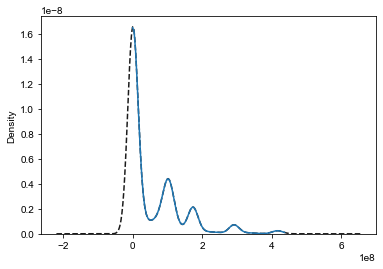

In [3]:
import numpy as np

updatetable=maptable[(maptable['update_count']!=0)]#排除更新时间为0的

print(len(updatetable.index),updatetable['update_avg'].max())

print(len(updatetable.index),updatetable['update_avg'].min())

dx=0.01

#x=np.arange(0, int(updatetable['update_avg'].max()), dx) 
updatetable['update_avg'].plot(kind='kde',style='k--')

import seaborn as sns
sns.set() 
#sns.kdeplot(updatetable['update_avg'].tolist())
sns.distplot(updatetable['update_avg'].tolist(),hist=False,kde_kws={'clip': (0.0, int(updatetable['update_avg'].max()))})
#sns.distplot(updatetable['update_avg'].tolist(),kde=False)

386018     4.492199e-02
386017     4.492199e-02
386016     4.492199e-02
386015     4.492199e-02
386014     4.492199e-02
               ...     
4706358    4.219129e+08
844234     4.267485e+08
531713     4.372946e+08
531712     4.372946e+08
531714     4.372946e+08
Name: update_avg, Length: 5896, dtype: float64

In [ ]:
    updatetable=maptable[(maptable['update_avg']>0.0)]
    
    plt.figure()
    
    updatetable['update_avg'].plot(kind='kde',style='k--')
    #updatetable['update_avg'].hist( cumulative = True )

    maptable = []